In [2]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import json 
import matplotlib.pyplot as plt

In [3]:
common_df=pd.read_csv(r"C:\Users\Svetlana\Documents\common_df2.csv")

In [4]:
data_folder = 'C:/Users/Svetlana/Documents/flink_metric_data_new/'
folder = []
for i in os.walk('C:/Users/Svetlana/Documents/flink_metric_data_new'):
    folder.append(i)

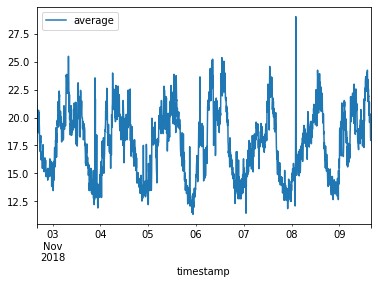

In [5]:
s=common_df.at[315, 'name']
with open(f"{data_folder}"+'/'+s) as f:
    data = json.load(f)
    df = pd.DataFrame(data['datapoints'])
    df.drop('unit',axis=1,inplace=True)
    df = df.set_index(['timestamp'])
    df.index = pd.to_datetime(df.index, unit='ms')
df.plot()

In [230]:
df_resample_90T = pd.DataFrame()
df_resample_90T['average'] = df.average.resample('90T').sum()

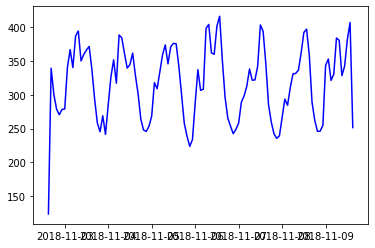

In [189]:
plt.plot(df_resample_90T.average, color='blue')

In [72]:
len(df_resample_90T)

113

<h5>попытки разобраться в LSTM</h5>

In [45]:
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Activation, Input, MaxPooling1D, Dropout
from tensorflow.keras.layers import AveragePooling1D, Conv1D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.utils import plot_model
from IPython.display import display, Image

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [92]:
train, test = df_resample_90T[0:100], df_resample_90T[100:]

In [36]:
scaler= MinMaxScaler()

In [93]:
scaler.fit(train)
scaled_train_data = (scaler.transform(train))
scaled_test_data = scaler.transform(test)

In [124]:
n_input = 13
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
lstm_model = Sequential()
lstm_model.add(LSTM(40, activation='relu', return_sequences=True,  input_shape=(n_input, n_features)))
lstm_model.add(LSTM(40, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 13, 40)            6720      
_________________________________________________________________
lstm_21 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 41        
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [116]:
lstm_model.fit_generator(generator,epochs=20)


Epoch 1/20
87/87 [==============================] - 7s 80ms/step - loss: 0.0695
Epoch 2/20
87/87 [==============================] - 2s 18ms/step - loss: 0.0434
Epoch 3/20
87/87 [==============================] - 2s 19ms/step - loss: 0.0388
Epoch 4/20
87/87 [==============================] - 2s 18ms/step - loss: 0.0357
Epoch 5/20
87/87 [==============================] - 2s 20ms/step - loss: 0.0328
Epoch 6/20
87/87 [==============================] - 2s 18ms/step - loss: 0.0276
Epoch 7/20
87/87 [==============================] - 2s 20ms/step - loss: 0.0292
Epoch 8/20
87/87 [==============================] - 2s 21ms/step - loss: 0.0279
Epoch 9/20
87/87 [==============================] - 2s 19ms/step - loss: 0.0251
Epoch 10/20
87/87 [==============================] - 2s 18ms/step - loss: 0.0223
Epoch 11/20
87/87 [==============================] - 2s 19ms/step - loss: 0.0247
Epoch 12/20
87/87 [==============================] - 2s 19ms/step - loss: 0.0225
Epoch 13/20
87/87 [==================

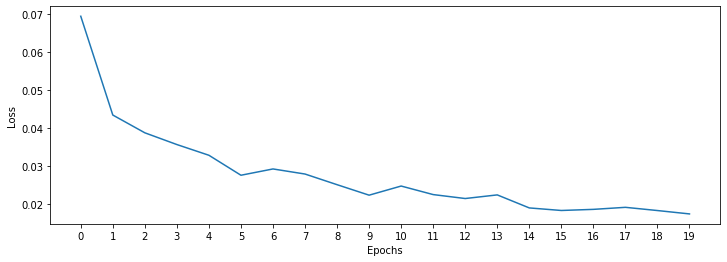

In [117]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [118]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [98]:
lstm_predictions_scaled


[array([0.14443982], dtype=float32),
 array([0.17583758], dtype=float32),
 array([0.19739738], dtype=float32),
 array([0.21587154], dtype=float32),
 array([0.23261178], dtype=float32),
 array([0.24703541], dtype=float32),
 array([0.2594935], dtype=float32),
 array([0.2694982], dtype=float32),
 array([0.27859494], dtype=float32),
 array([0.2867091], dtype=float32),
 array([0.29386774], dtype=float32),
 array([0.29916936], dtype=float32),
 array([0.30275005], dtype=float32)]

In [119]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[1012.44645179],
       [ 993.34382901],
       [1048.96562585],
       [1147.96321051],
       [1273.68712858],
       [1415.68925067],
       [1556.9551076 ],
       [1685.71121183],
       [1758.59984731],
       [1766.17797439],
       [1708.599636  ],
       [1587.98765691],
       [1429.23931279]])

In [120]:
test['LSTM_Predictions'] = lstm_predictions
test

C:\Users\Svetlana\anaconda33\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,average,LSTM_Predictions
timestamp,,
2018-11-08 21:00:00,739.34,1012.446452
2018-11-08 22:30:00,848.67,993.343829
2018-11-09 00:00:00,946.46,1048.965626
2018-11-09 01:30:00,1046.82,1147.963211
2018-11-09 03:00:00,1264.73,1273.687129
2018-11-09 04:30:00,1134.46,1415.689251
2018-11-09 06:00:00,1476.31,1556.955108
2018-11-09 07:30:00,1567.89,1685.711212
2018-11-09 09:00:00,1900.55,1758.599847


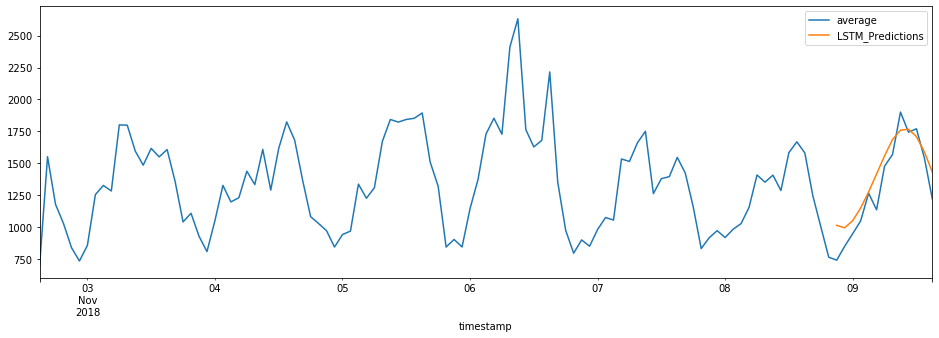

In [121]:
df_resample_90T['average'].plot(figsize = (16,5), legend=True)
test['LSTM_Predictions'].plot(legend = True);

In [231]:
df_resample_90T = scaler.fit_transform(df_resample_90T)

In [232]:
train, test = df_resample_90T[0:100], df_resample_90T[100:]

In [217]:
len(test)

13

numpy.ndarray

In [233]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i + look_back,0])
    return np.array(dataX), np.array(dataY)

In [234]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [235]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [236]:
model = Sequential()
model.add(LSTM(4,input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
98/98 - 2s - loss: 0.3737
Epoch 2/100
98/98 - 0s - loss: 0.2061
Epoch 3/100
98/98 - 0s - loss: 0.0910
Epoch 4/100
98/98 - 0s - loss: 0.0356
Epoch 5/100
98/98 - 0s - loss: 0.0225
Epoch 6/100
98/98 - 0s - loss: 0.0210
Epoch 7/100
98/98 - 0s - loss: 0.0204
Epoch 8/100
98/98 - 0s - loss: 0.0200
Epoch 9/100
98/98 - 0s - loss: 0.0200
Epoch 10/100
98/98 - 0s - loss: 0.0195
Epoch 11/100
98/98 - 0s - loss: 0.0192
Epoch 12/100
98/98 - 0s - loss: 0.0189
Epoch 13/100
98/98 - 0s - loss: 0.0188
Epoch 14/100
98/98 - 0s - loss: 0.0180
Epoch 15/100
98/98 - 0s - loss: 0.0178
Epoch 16/100
98/98 - 0s - loss: 0.0176
Epoch 17/100
98/98 - 0s - loss: 0.0175
Epoch 18/100
98/98 - 0s - loss: 0.0171
Epoch 19/100
98/98 - 0s - loss: 0.0168
Epoch 20/100
98/98 - 0s - loss: 0.0164
Epoch 21/100
98/98 - 0s - loss: 0.0162
Epoch 22/100
98/98 - 0s - loss: 0.0160
Epoch 23/100
98/98 - 0s - loss: 0.0157
Epoch 24/100
98/98 - 0s - loss: 0.0156
Epoch 25/100
98/98 - 0s - loss: 0.0154
Epoch 26/100
98/98 - 0s - loss: 0.

In [237]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [238]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [204]:
import math
from sklearn.metrics import mean_squared_error

In [239]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f RMSE' % (trainScore))
testScore =mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1126.84 RMSE
Test Score: 1287.64 RMSE


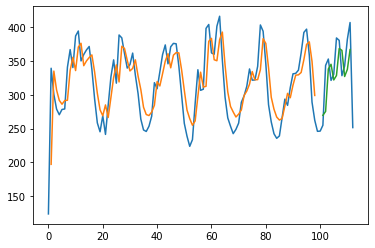

In [240]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_resample_90T)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_resample_90T)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_resample_90T)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_resample_90T))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()